In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee

<IPython.core.display.Javascript object>


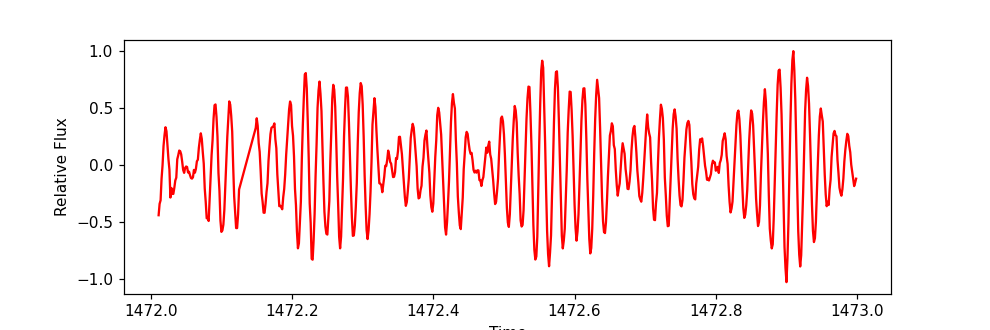

In [26]:
### TESS data import ###
data = np.loadtxt("TESS_data.dat",usecols=(0,1))
time = data[:,0][(1472<data[:,0])&(data[:,0]<1473)]
# à prendre vers 1472
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1][(1472<data[:,0])&(data[:,0]<1473)]
#flux = np.reshape(flux,[32,int(62976/32)])
flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))

fig = plt.figure(figsize=(9,3))
ax = plt.gca()
#ax.scatter(time,flux,c="r",s=1)
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Relative Flux")
fig.show()

In [4]:
flux_error = 0.05*flux

In [5]:
### GP Model ###
bounds = dict(log_S0= (0,10), log_Q = (0,10), log_omega0 = (0,10))
kernel = terms.SHOTerm(log_S0=6.5, log_Q=2.5, log_omega0=5.7)

gp = celerite.GP(kernel,mean=np.mean(flux))
gp.compute(time,yerr=flux_error)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -4025.8869648973614
parameter_dict:
OrderedDict([('kernel:log_S0', 6.5), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.7)])



In [6]:
x = np.linspace(np.min(time),np.max(time),2000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


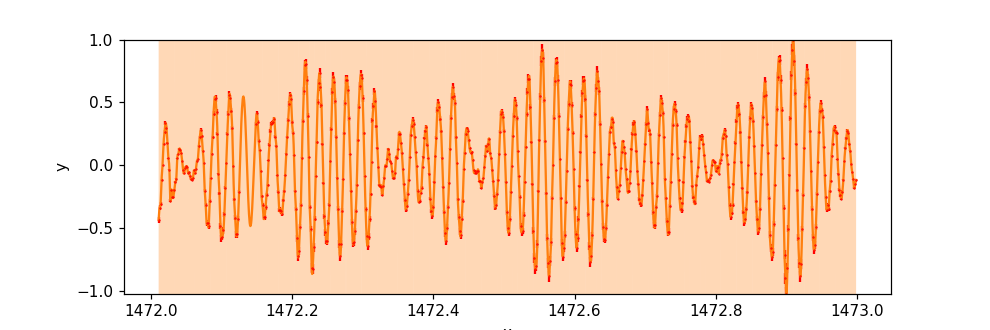

In [7]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=flux_error,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [8]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -614.3022470676183
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   3.49928087, 2203.25516693, 1801.24457074])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 276
      nit: 12
   status: 0
  success: True
        x: array([4.76322697, 2.66434447, 2.47523053])
Final log-likelihood: 614.3022470676183
[117.12327034  14.35853408  11.8844465 ]
Parameters: OrderedDict([('kernel:log_S0', 4.763226972841583), ('kernel:log_Q', 2.6643444745044444), ('kernel:log_omega0', 2.475230538433955)])


C:\ProgramData\Anaconda3\lib\site-packages\celerite\terms.py:500: RuntimeWarning: invalid value encountered in double_scalars
  0.5*w0/Q*np.array([1.0-f, 1.0+f])


In [18]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)
P = 2*np.pi/(np.exp(results.x[2])*60*24)
P

0.00036714567480462086

<IPython.core.display.Javascript object>


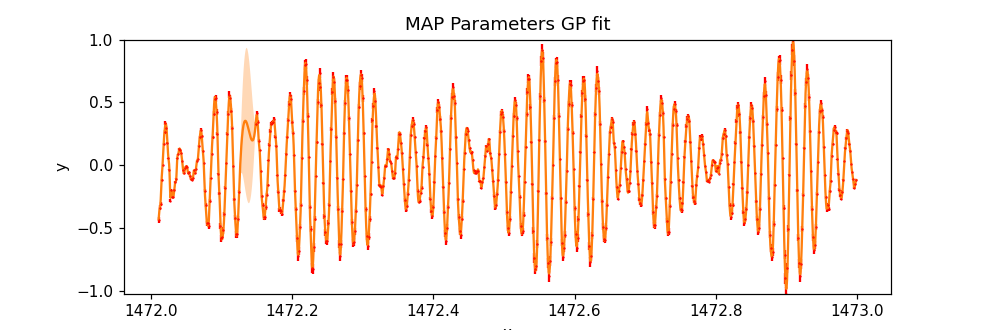

In [10]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=flux_error,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [11]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else np.inf

In [12]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((0 < params[0] < 10) and (0 < params[1] < 10) and (0 < params[2] < 10)) :
        return 0
    return -np.inf

In [13]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else np.inf

In [14]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000)
print("Finished")

Running burn-in...
Running production...
Finished


In [15]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', 0.09453518007585615), ('kernel:log_Q', 0.023217092282427798), ('kernel:log_omega0', 3.6591099525814257)])
Final MCMC log likelihood: 638.9856509074914


<IPython.core.display.Javascript object>


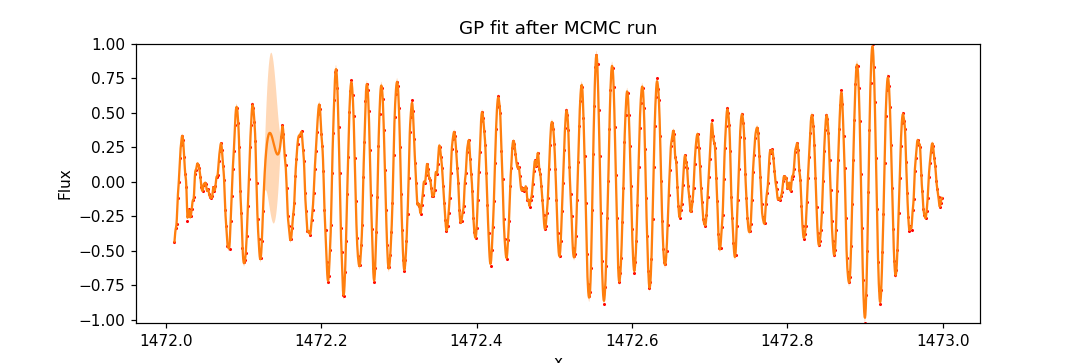

In [16]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

In [28]:
w = np.exp(gp.get_parameter_vector())
print(w)
P = 2*np.pi*24*60/w
P

51.52787552633439


27.94603863037315